<a href="https://colab.research.google.com/github/alizaasifb/Handwritten-Digit-Classification/blob/main/Handwritten_Digit_Classification_With_Feedforward_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Part 1: Importing Libraries**


---



In [ ]:
# IMPORTING IMPORTANT LIBRARIES

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


## **Part 2: Downloading and Preprocessing Data**

---



In [ ]:
# DOWNLOADING MNIST DATASET

ds = MNIST(root='hello/', download=True, transform=ToTensor())
test_ds = MNIST(root='hello/', train=False, transform=ToTensor())
len(ds), len(test_ds)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting hello/MNIST/raw/train-images-idx3-ubyte.gz to hello/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting hello/MNIST/raw/train-labels-idx1-ubyte.gz to hello/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting hello/MNIST/raw/t10k-images-idx3-ubyte.gz to hello/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting hello/MNIST/raw/t10k-labels-idx1-ubyte.gz to hello/MNIST/raw



(60000, 10000)

In [ ]:
# SPLITTING THE DATASET INTO TRAINING AND VALIDATION

train_ds, val_ds = random_split(ds, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
# DEFINING THE TRAINING, VALIDATION, TESTING DATALOADERS

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

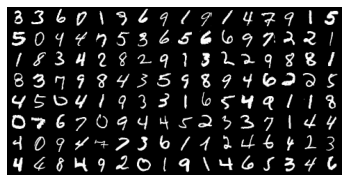

In [ ]:
# VISUALIZING A BATCH OF IMAGES

for images, _ in train_loader:
  grid = make_grid(images, nrow=16).permute((1, 2, 0))
  plt.imshow(grid)
  plt.axis('off')
  break

## **Part 3: Compiling the Model**

---



In [ ]:
# EXTENDING THE NN.MODULE CLASS


class MnistModel(nn.Module):

  def __init__(self, input_size, output_size):
    super().__init__()
    self.linear1 = nn.Linear(input_size, 64)
    self.linear2 = nn.Linear(64, 32)
    self.linear3 = nn.Linear(32, 16)
    self.linear4 = nn.Linear(16, output_size)

  def forward(self, x_batch):
    outputs = x_batch.reshape(-1, 784)
    outputs = self.linear4(F.relu(self.linear3(F.relu(self.linear2(F.relu(self.linear1(outputs)))))))
    return outputs

## **Part 4: Defining Loss and Accuracy**

---



In [ ]:
# DEFINING ACCURACY FUNCTION

def accuracy_score(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  correct_preds = torch.sum(preds==labels).item()
  total_preds = len(preds)
  accuracy = torch.tensor(correct_preds/total_preds)
  return accuracy

In [ ]:
# DEFINING VALIDATION FUNCTIONS

def validation_step(model, batch):
  images, labels = batch
  loss = F.cross_entropy(model.forward(images), labels)
  acc = accuracy_score(model.forward(images), labels)
  return {'val_loss':loss, 'val_acc':acc}

def validation_epoch_end(outputs):
  batch_losses = [x['val_loss'] for x in outputs]
  epoch_loss = torch.stack(batch_losses).mean()
  batch_accs = [x['val_acc'] for x in outputs]
  epoch_acc = torch.stack(batch_accs).mean()
  return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

def evaluate(model, val_loader):
  metrics = [validation_step(model, batch) for batch in val_loader]
  metrics = validation_epoch_end(metrics)
  return metrics

## **Part 5: Training the Model**

---



In [ ]:
# DEFINING THE FIT FUNCTION

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)

  for epoch in range(epochs):

    for batch in train_loader:
      images, labels = batch
      loss = F.cross_entropy(model.forward(images), labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    metrics = evaluate(model, val_loader)
    print('Epoch #', epoch+1, '|', 'Validation loss:', round(metrics['val_loss'], 3), '|', 'Validation accuracy:', round(metrics['val_acc']*100, 3), '%')

    history.append(metrics)

  return history

In [ ]:
# TRAINING THE MODEL

model = MnistModel(784, 10)

history = [evaluate(model, val_loader)]
print('Metrics before training:')
print(history)
print()
print('Metrics after training for x number of epochs:')
history += fit(10, 0.4, model, train_loader, val_loader)

Metrics before training:
[{'val_loss': 2.3061790466308594, 'val_acc': 0.1005859375}]

Metrics after training for x number of epochs:
Epoch # 1 | Validation loss: 0.236 | Validation accuracy: 92.783 %
Epoch # 2 | Validation loss: 0.154 | Validation accuracy: 95.186 %
Epoch # 3 | Validation loss: 0.146 | Validation accuracy: 95.723 %
Epoch # 4 | Validation loss: 0.122 | Validation accuracy: 96.367 %
Epoch # 5 | Validation loss: 0.123 | Validation accuracy: 96.475 %
Epoch # 6 | Validation loss: 0.129 | Validation accuracy: 96.162 %
Epoch # 7 | Validation loss: 0.131 | Validation accuracy: 95.82 %
Epoch # 8 | Validation loss: 0.11 | Validation accuracy: 96.816 %


Text(0.5, 1.0, 'loss vs no of epochs')

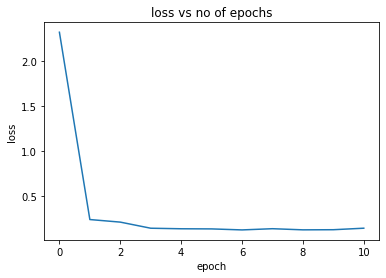

In [ ]:
# PLOTTING LOSS

losses = [x['val_loss'] for x in history]
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs no of epochs')

Text(0.5, 1.0, 'accuracy vs no of epochs')

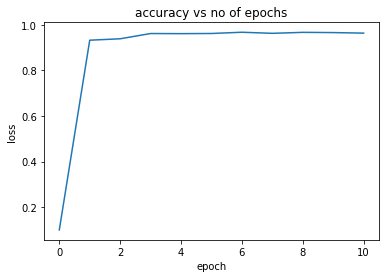

In [ ]:
# PLOTTING ACCURACIES

accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('accuracy vs no of epochs')

## **Part 6: Testing the Model**

---



Label: 9
Predicted: tensor([9])


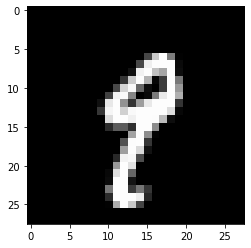

In [ ]:
# DEFINING HELPER FUNCTION TO PREDICT IMAGES FROM THE TEST SET

def predict_image(image):
  image = image.reshape(-1, 784)
  outputs = model.forward(image)
  _, prediction = torch.max(outputs, dim=1)
  return prediction

image, label = test_ds[78]
plt.imshow(image[0], cmap='gray')
print('Label:', label)
print('Predicted:', predict_image(image))

## **Part 7: Deploying the Model on a User Interface**


---



In [ ]:
# CREATE A HELPER FUNNCTION TO PREDICT WITH USER INPUT

def predict_sketch(sketch):
  transform = transforms.ToTensor()
  tensor = transform(sketch)
  input_tensor = tensor.unsqueeze(0)
  outputs = model.forward(input_tensor)
  _, prediction = torch.max(outputs, dim=1)

  return prediction[0].item()

In [ ]:
# Installing Gradio

!pip3 install gradio

     |████████████████████████████████| 659 kB 3.2 MB/s 
     |████████████████████████████████| 2.0 MB 62.8 MB/s 
     |████████████████████████████████| 255 kB 59.1 MB/s 
     |████████████████████████████████| 211 kB 54.4 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 37.1 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 144 kB 42.3 MB/s 
     |████████████████████████████████| 271 kB 49.8 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 4.8 MB/s 
     |████████████████████████████████| 10.9 MB 39.5 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 61 kB 428 kB/s 
     |████████████████████████████████| 856 kB 60.5 MB/s 
     |████████████████████████

In [ ]:
import gradio as gr
iface = gr.Interface(fn=predict_sketch, inputs='sketchpad', outputs='label').launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://56841.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
